In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.dm import DataModule2 as DataModule
from src.models.unet_ltae import UNetLTAE as Module

In [3]:
import torch 

checkpoint = 'checkpoints/dfta_oc-val_metric=29.47327-epoch=368.ckpt'

hparams = {
	'encoder': 'resnet18',
    'pretrained': 'imagenet',
    'in_channels_s1': 2,
    'in_channels_s2': 6,
    'seq_len': 12,
    'n_head': 16,
}

# module = UNet.load_from_checkpoint(checkpoint)
# module.hparams

state_dict = torch.load(checkpoint)['state_dict']
module = Module(hparams)
module.load_state_dict(state_dict)

<All keys matched successfully>

In [4]:
dm = DataModule(val_size=0.2, num_workers=10, pin_memory=True, batch_size=4)
dm.setup()

train: 6951
val: 1738
test: 2773


In [16]:
class Identity:
    def __call__(self, x):
        return x

class Rot90:
    def __init__(self, axes=(2, 3)):
        self.axes = axes
    def __call__(self, x):
        return torch.rot90(x, 1, self.axes)

class Rot180:
    def __init__(self, axes=(2, 3)):
        self.axes = axes
    def __call__(self, x):
        return torch.rot90(x, 2, self.axes)

class Rot270:
    def __init__(self, axes=(2, 3)):
        self.axes = axes
    def __call__(self, x):
        return torch.rot90(x, 3, self.axes)

class Flip:
    def __init__(self, axis=2):
        self.axis = axis
    def __call__(self, x):
        return torch.flip(x, [self.axis])

class Transpose:
    def __init__(self, axes=(2, 3)):
        self.axes = axes
    def __call__(self, x):
        return torch.transpose(x, self.axes[0], self.axes[1])

trans = [
    (Identity(), Identity()),
    (Rot90(), Rot270()),
    (Rot180(), Rot180()),
    (Rot270(), Rot90()),
    (Flip(2), Flip(2)),
    (Flip(3), Flip(3)),
    (Transpose(), Transpose()),
]

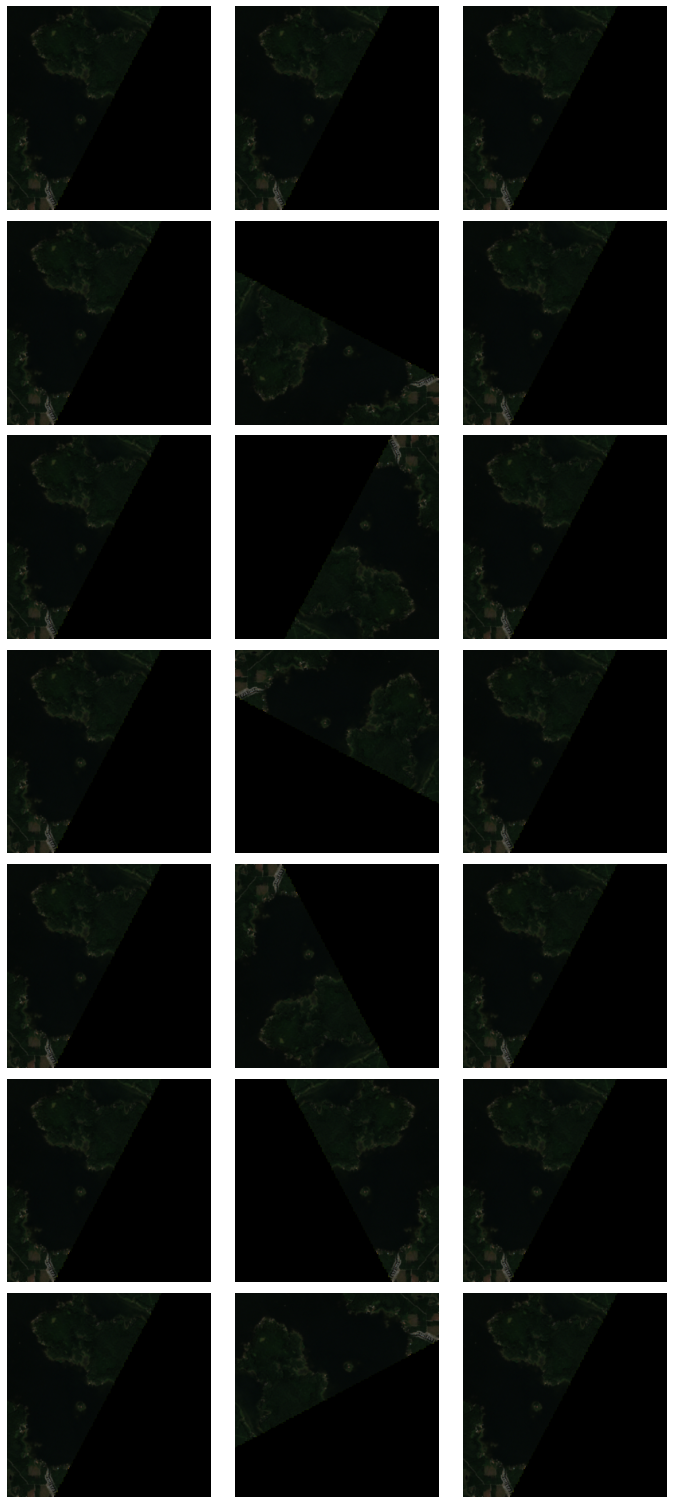

In [17]:
import torch 
import matplotlib.pyplot as plt 

dl = dm.train_dataloader(batch_size=1)
s1, s2, labels = next(iter(dl))

def get_image(x):
	return x[0][-1][...,:3]

fig, ax = plt.subplots(len(trans), 3, figsize=(10, 3*len(trans)))
for i, (t1, t2) in enumerate(trans):
	ax[i, 0].imshow(get_image(s2))
	ax[i, 0].axis('off')
	ax[i, 1].imshow(get_image(t1(s2)))
	ax[i, 1].axis('off')
	ax[i, 2].imshow(get_image(t2(t1(s2))))
	ax[i, 2].axis('off')
plt.tight_layout()
plt.show()

In [19]:
from tqdm import tqdm 

trans = [
    (Identity(), Identity()),
    (Rot90(), Rot270(axes=(1, 2))),
    (Rot180(), Rot180(axes=(1, 2))),
    (Rot270(), Rot90(axes=(1, 2))),
    (Flip(2), Flip(1)),
    (Flip(3), Flip(2)),
    (Transpose(), Transpose(axes=(1, 2))),
]

dl = dm.val_dataloader(batch_size=4, shuffle=False)
s1, s2, labels = next(iter(dl))

module.cuda(1)
metrics = []
for batch in tqdm(dl):
    x1, x2, y = batch
    s1, s2 = x1.cuda(1), x2.cuda(1)
    preds = []
    for t1, t2 in trans:
        preds.append(t2(module.predict(t1(s1), t1(s2))))
    preds = torch.stack(preds).mean(0).cpu()
    metrics.append(torch.mean(torch.sqrt(torch.mean((preds * 12905.3 - y * 12905.3)**2, dim=(1, 2)))))

torch.mean(torch.tensor(metrics)).item()

100%|██████████| 435/435 [02:31<00:00,  2.87it/s]


28.87995719909668

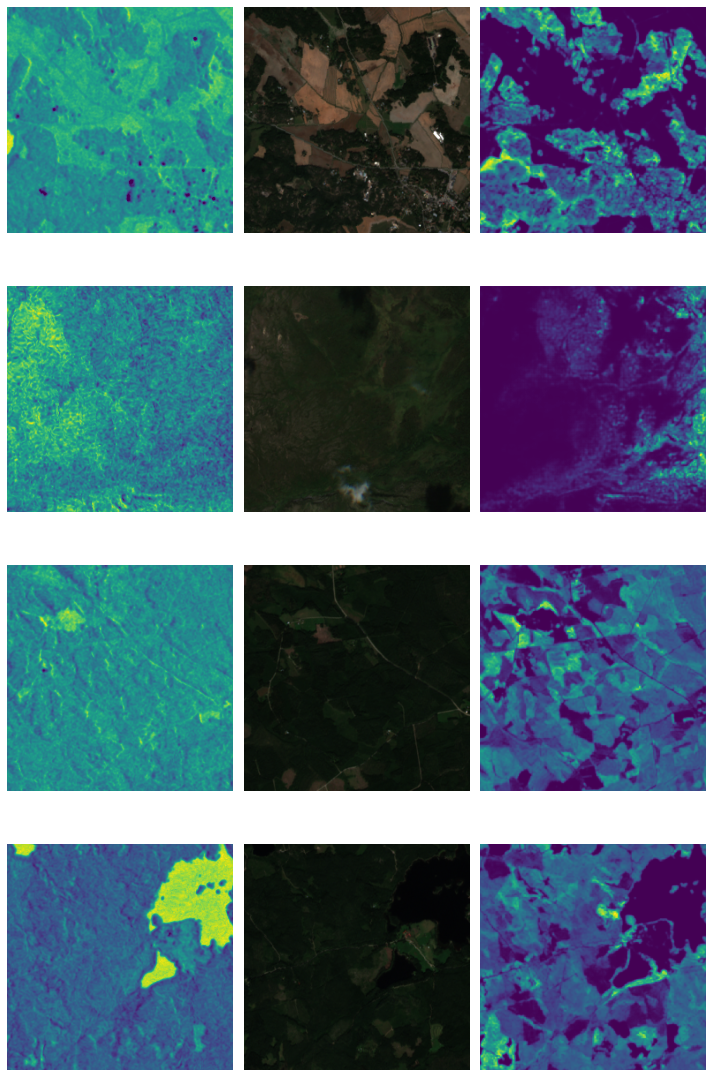

In [21]:
trans = [
    (Identity(), Identity()),
    (Rot90(), Rot270(axes=(1, 2))),
    (Rot180(), Rot180(axes=(1, 2))),
    (Rot270(), Rot90(axes=(1, 2))),
    (Flip(2), Flip(1)),
    (Flip(3), Flip(2)),
    (Transpose(), Transpose(axes=(1, 2))),
]

dl = dm.test_dataloader(batch_size=4)
s1, s2, _ = next(iter(dl))
s1, s2 = s1.cuda(1), s2.cuda(1)

module.cuda(1)
preds = []
for t1, t2 in trans:
    preds.append(t2(module.predict(t1(s1), t1(s2))))
preds = torch.stack(preds).mean(0).cpu()

fig, ax = plt.subplots(4, 3, figsize=(10, 16))
for i in range(4):
	ax[i, 0].imshow(s1[i][-1][...,0].cpu())
	ax[i, 0].axis('off')
	ax[i, 1].imshow(s2[i][-1][...,:3].cpu())
	ax[i, 1].axis('off')
	ax[i, 2].imshow(preds[i])
	ax[i, 2].axis('off')
plt.tight_layout()
plt.show()

In [22]:
from tqdm import tqdm 
from skimage.io import imsave

dl = dm.test_dataloader(batch_size=4)
module.cuda(1)

trans = [
    (Identity(), Identity()),
    (Rot90(), Rot270(axes=(1, 2))),
    (Rot180(), Rot180(axes=(1, 2))),
    (Rot270(), Rot90(axes=(1, 2))),
    (Flip(2), Flip(1)),
    (Flip(3), Flip(2)),
    (Transpose(), Transpose(axes=(1, 2))),
]

for s1, s2, chip_ids in tqdm(dl):
	s1, s2 = s1.cuda(1), s2.cuda(1)
	preds = []
	for t1, t2 in trans:
		preds.append(t2(module.predict(t1(s1), t1(s2))))
	preds = torch.stack(preds).mean(0)
	preds = preds * 12905.3
	for chip_id, pred in zip(chip_ids, preds.cpu().numpy()):
		imsave(f'./submission/{chip_id}_agbm.tif', pred)

100%|██████████| 694/694 [04:04<00:00,  2.83it/s]


In [23]:
import glob 

files = glob.glob('./submission/*.tif')
assert len(files) == 2773

In [24]:
# zip folder 

import shutil
shutil.make_archive('submission', 'zip', './submission')

'/home/juan/Desktop/competis/TheBioMassters/submission.zip'

In [25]:
import rasterio as rio
import numpy as np

ix = np.random.randint(0, len(files))
ds = rio.open(files[ix])

ds.indexes, ds.shape, ds.count

/home/juan/miniconda3/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


((1,), (256, 256), 1)

In [26]:
x = ds.read(1)

x.shape, x.dtype, x.min(), x.max()

((256, 256), dtype('float32'), 0.0030501469, 298.33328)

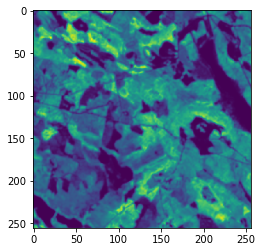

In [27]:
plt.imshow(x)
plt.show()